### Install Package

In [2]:
# Uncomment the below code for first time to install packages
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz
# !python -m spacy download en_core_web_md

### Load Libraries

In [39]:
import numpy as np
import re
import pandas as pd
import spacy
import scispacy
import torch
from collections import Counter
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

### Load raw data

In [4]:
def load_csv(filename, compressed=False):
    """Load a CSV file into a Pandas DataFrame."""
    if compressed:
        return pd.read_csv(filename, compression='gzip')
    return pd.read_csv(filename)

In [5]:
# Upload the files from local to colab
icd9_file = "/content/DIAGNOSES_ICD.csv.gz"
noteevents_file = "/content/NOTEEVENTS.csv.gz"

In [7]:
# load ICD9 codes
diagnoses_df = load_csv(icd9_file, compressed=True)
diagnoses_df.info()
diagnoses_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [8]:
# load notes
notes_df = load_csv(noteevents_file, compressed=True)
notes_df.info()
notes_df.head()

<ipython-input-4-408ea51dcdee>:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename, compression='gzip')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


### Load models

loads Spacy, SciSpacy and BioBERT

In [9]:
# Load Spacy
spacy_model = spacy.load("en_core_web_md")  # General NLP

# Load SciSpacy
scispacy_model = spacy.load("en_core_sci_md")  # Medical NLP

# Load BioBERT tokenizer and model
biobert_tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
biobert_model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Analyse a particular disease based on ICD code

In [20]:
def get_patients_by_icd9(diagnoses_df, icd9_code):
    filtered_subject_ids = diagnoses_df.loc[diagnoses_df["ICD9_CODE"] == icd9_code, "SUBJECT_ID"].tolist()
    print(f"Found {len(filtered_subject_ids)} patients with ICD-9 code {icd9_code}.")
    return filtered_subject_ids

ICD9_CODE = "430"
arr_subject_id = get_patients_by_icd9(diagnoses_df, ICD9_CODE)
print('length of array is:',len(arr_subject_id))


Found 658 patients with ICD-9 code 430.
length of array is: 658


### Create ICD code filtered Dataset

In [23]:
def filter_notes_by_subject_ids(notes_df, subject_ids, category="Social Work"):
    filtered_notes = notes_df[(notes_df["SUBJECT_ID"].isin(subject_ids)) & (notes_df["CATEGORY"] == category)]
    return filtered_notes[["SUBJECT_ID", "CATEGORY", "TEXT"]]

In [25]:
patients_df = filter_notes_by_subject_ids(notes_df, arr_subject_id)
patients_df.head()

,SUBJECT_ID,CATEGORY,TEXT
354103,22933,Social Work,Family Information\n Next of [**Doctor First...
370960,22933,Social Work,Family Information\n Next of [**Doctor First...
373261,22933,Social Work,Family Information\n Next of [**Doctor First...
379030,30829,Social Work,Social Work:\n Pt is 61 yr-old gentleman adm...
402064,6884,Social Work,SW Note:\n This worker has participated in t...


### Preprocess Text

In [26]:
def clean_and_preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()
    text = ' '.join(text.split())

    doc = spacy_model(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

In [27]:
patients_df['TEXT'] = patients_df['TEXT'].apply(clean_and_preprocess_text)

### Extract Entities

In [28]:
def extract_entities(text_series, model, entity_types=None):
    entities = []
    for doc in model.pipe(text_series.astype(str), disable=["parser", "tagger"]):
        for ent in doc.ents:
            if entity_types is None or ent.label_.lower() in entity_types:
                entities.append(ent.text.lower())
    return entities

In [29]:
# Extract entities
spacy_entities = extract_entities(patients_df['TEXT'], spacy_model)
scispacy_entities = extract_entities(patients_df['TEXT'], scispacy_model)


/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [30]:
def extract_entities_biobert(text_series):
    entities = []
    for text in text_series.astype(str):
        tokens = biobert_tokenizer.tokenize(text)
        token_ids = biobert_tokenizer.convert_tokens_to_ids(tokens)
        input_tensor = torch.tensor([token_ids])

        with torch.no_grad():
            outputs = biobert_model(input_tensor)

        extracted_terms = biobert_tokenizer.convert_ids_to_tokens(input_tensor[0])
        entities.extend([word.lower() for word in extracted_terms if len(word) > 2])

    return entities

In [31]:
biobert_entities = extract_entities_biobert(patients_df['TEXT'])

###  Get Top Entities

In [32]:
def get_top_entities(entities, top_n=10):
    return Counter(entities).most_common(top_n)

In [33]:
# Compute entity statistics
top_spacy_disease = get_top_entities(spacy_entities, 10)
top_scispacy_disease = get_top_entities(scispacy_entities, 10)
top_biobert_disease = get_top_entities(biobert_entities, 10)

In [55]:
def print_list(arr):
  for i in arr:
    print(i)

# Print statistics
print("\n Top 10 Entities from Spacy:")
print_list(top_spacy_disease)

print("\n Top 10 Entities from SciSpacy:")
print_list(top_scispacy_disease)

print("\n Top 10 Entities from BioBERT:")
print_list(top_biobert_disease)


 Top 10 Entities from Spacy:
('pt s', 189)
('ni', 72)
('today', 33)
('un', 29)
('pt', 26)
('ni ni', 17)
('sw', 16)
('namepattern namepattern licsw', 14)
('namepattern namepattern', 13)
('yesterday', 9)

 Top 10 Entities from SciSpacy:
('mother', 99)
('information', 63)
('family', 54)
('patient', 53)
('communication', 26)
('female', 25)
('condition', 21)
('social security', 21)
('progress', 18)
('living situation', 17)

 Top 10 Entities from BioBERT:
('##t', 592)
('family', 225)
('##n', 147)
('##w', 126)
('hospital', 122)
('mother', 119)
('name', 115)
('##pa', 114)
('##tter', 113)
('information', 90)


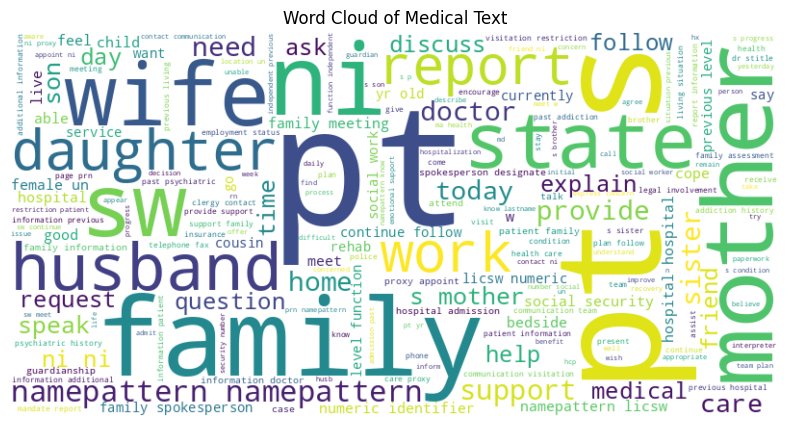

In [54]:
from wordcloud import WordCloud
# Generate word cloud

def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud of Medical Text")
    plt.show()
# Generate word cloud
all_text = ' '.join(patients_df["TEXT"].tolist())
generate_word_cloud(all_text)

### Create word 2 vector embeddings

In [35]:
def train_word2vec(entities, vector_size=100, window=5, min_count=2):
    model = Word2Vec([entities], vector_size=vector_size, window=window, min_count=min_count, workers=4)
    return model

In [36]:
# Train Word2Vec
spacy_model_w2v = train_word2vec(spacy_entities)
scispacy_model_w2v = train_word2vec(scispacy_entities)
biobert_model_w2v = train_word2vec(biobert_entities)

### Plot embeddings - TSNE

In [37]:
def reduce_dimensions(model):
    """Reduce dimensions of word embeddings using t-SNE."""
    if not model.wv.index_to_key:
        print("Warning: No words found in the Word2Vec model.")
        return np.array([]), []

    word_vectors = np.array([model.wv[word] for word in model.wv.index_to_key])

    # Ensure perplexity is not greater than the number of samples
    perplexity = min(30, len(word_vectors) - 1)

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced_vectors = tsne.fit_transform(word_vectors)

    return reduced_vectors, model.wv.index_to_key

In [40]:
spacy_reduced, spacy_words = reduce_dimensions(spacy_model_w2v)
scispacy_reduced, scispacy_words = reduce_dimensions(scispacy_model_w2v)
biobert_reduced, biobert_words = reduce_dimensions(biobert_model_w2v)

In [41]:
def plot_tsne(reduced_vectors, words, title):
    """Plot t-SNE visualization of word embeddings."""
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=reduced_vectors[:, 0], y=reduced_vectors[:, 1])

    for word, (x, y) in zip(words, reduced_vectors):
        plt.text(x, y, word, fontsize=8)

    plt.title(title)
    plt.show()

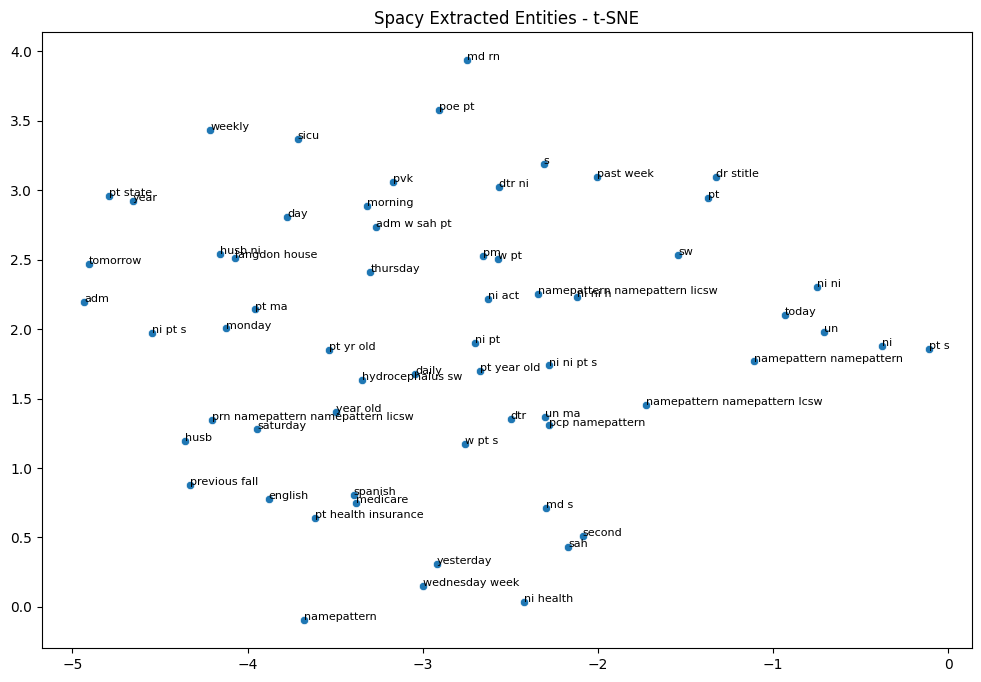

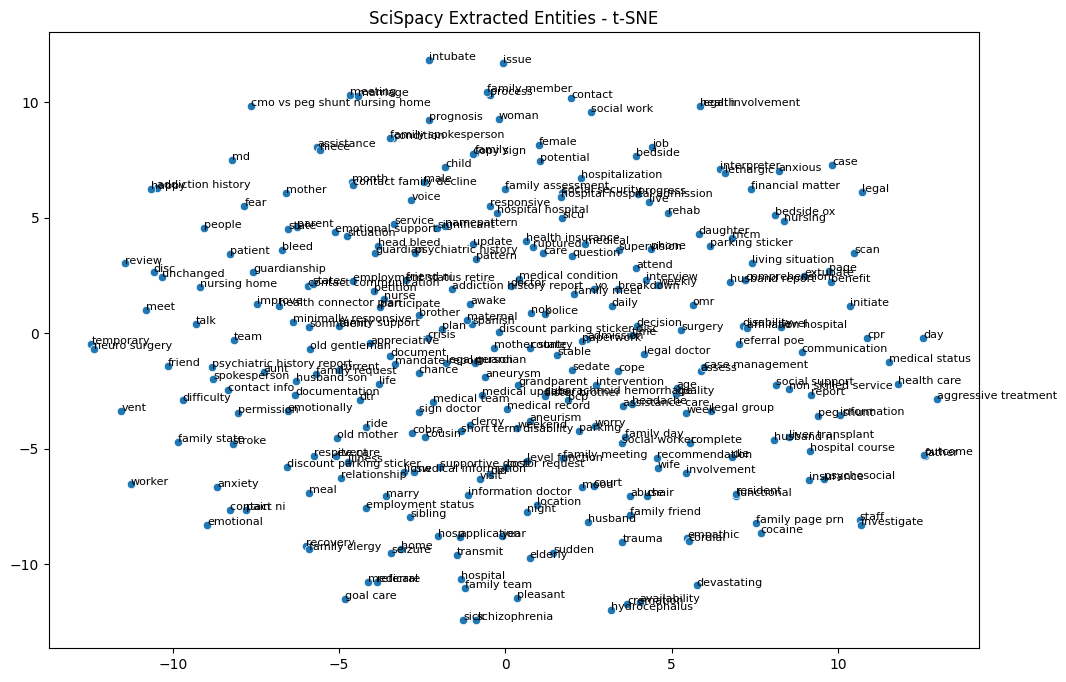

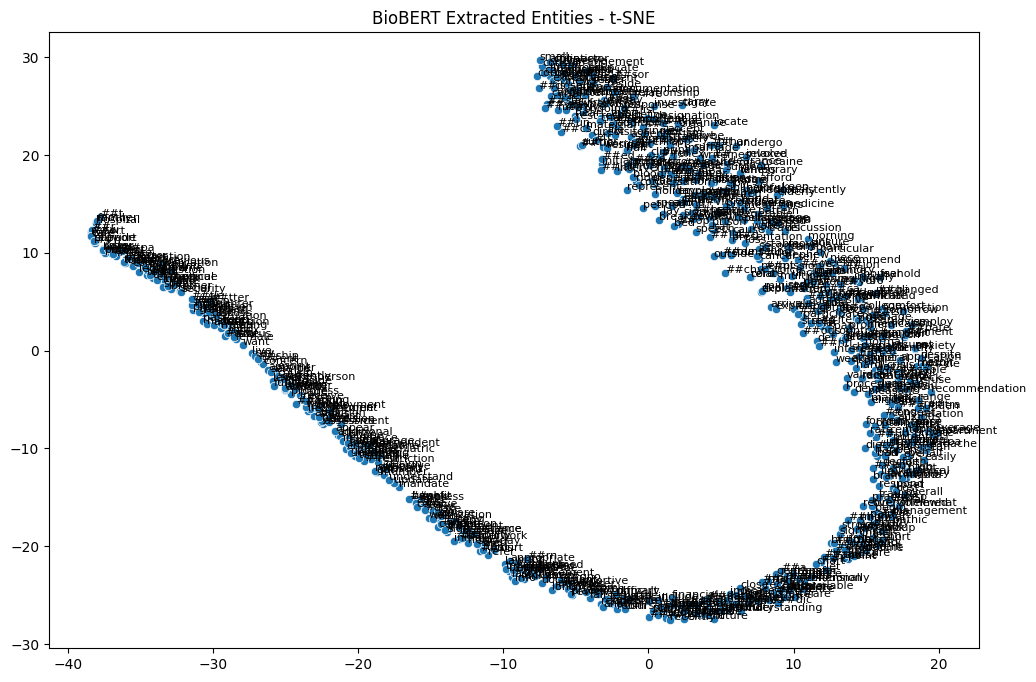

In [42]:
# Plot t-SNE
plot_tsne(spacy_reduced, spacy_words, "Spacy Extracted Entities - t-SNE")
plot_tsne(scispacy_reduced, scispacy_words, "SciSpacy Extracted Entities - t-SNE")
plot_tsne(biobert_reduced, biobert_words, "BioBERT Extracted Entities - t-SNE")

In [45]:
# Generate word cloud
all_text = ' '.join(df["text"].tolist())
generate_word_cloud(all_text)
def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud of Medical Text")
    plt.show()
# Generate word cloud
all_text = ' '.join(df["text"].tolist())
generate_word_cloud(all_text)